<a href="https://colab.research.google.com/github/KevinrealG/Series_de_tiempo/blob/main/02_Aplying_arima_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Datos y Librerias

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
from sklearn.linear_model import LinearRegression

<ipython-input-1-03e1ba467115>:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


Fremont Bridge Sidewalks, south of N 34th St
!curl -o FremontBridge.csv https://data.seattle.gov/api/views/65db-xm6k/rows.csv?accessType=DOWNLOAD

The Fremont Bridge Bicycle Counter began operation in October 2012 and records the number of bikes that cross the bridge using the pedestrian/bicycle pathways. Inductive loops on the east and west pathways count the passing of bicycles regardless of travel direction. The data consists of a date/time field: Date, east pathway count field: Fremont Bridge NB, and west pathway count field: Fremont Bridge SB. The count fields represent the total bicycles detected during the specified one hour period. Direction of travel is not specified, but in general most traffic in the Fremont Bridge NB field is travelling northbound and most traffic in the Fremont Bridge SB field is travelling southbound.


In [2]:
data = pd.read_csv('https://data.seattle.gov/resource/65db-xm6k.csv', index_col='date',parse_dates=True)

In [3]:
data.head()

,fremont_bridge,fremont_bridge_sb,fremont_bridge_nb
date,,,
2023-11-30 23:00:00,9,6,3
2023-11-30 22:00:00,21,4,17
2023-11-30 21:00:00,21,11,10
2023-11-30 20:00:00,35,14,21
2023-11-30 19:00:00,67,19,48


In [4]:
# prompt: sort by date

data.sort_index()


,fremont_bridge,fremont_bridge_sb,fremont_bridge_nb
date,,,
2023-10-20 08:00:00,249,89,160
2023-10-20 09:00:00,156,46,110
2023-10-20 10:00:00,97,34,63
2023-10-20 11:00:00,86,40,46
2023-10-20 12:00:00,100,40,60
...,...,...,...
2023-11-30 19:00:00,67,19,48
2023-11-30 20:00:00,35,14,21
2023-11-30 21:00:00,21,11,10


Text(0, 0.5, 'Number of bikes')

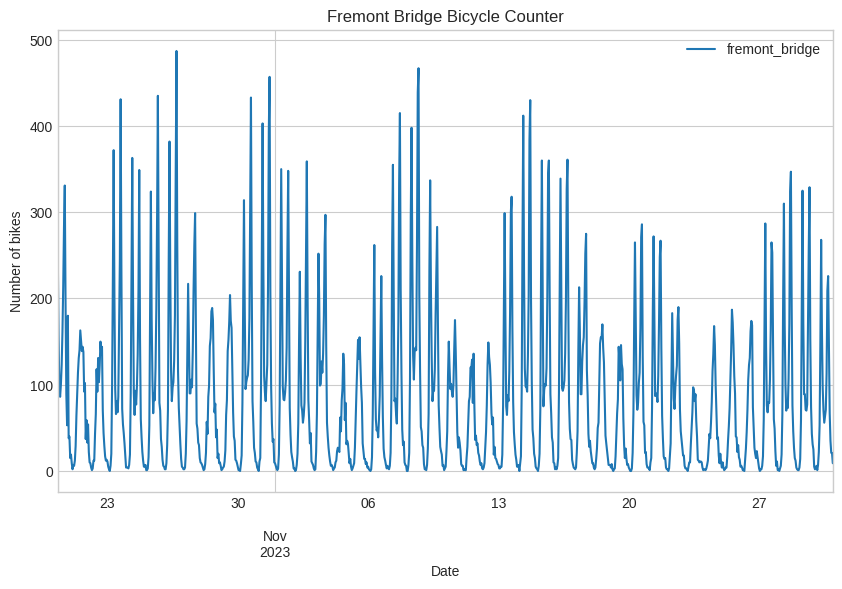

In [5]:
# prompt: plot fremont_bridge data with titles

data[["fremont_bridge"]].plot(title='Fremont Bridge Bicycle Counter', figsize=(10, 6))
plt.xlabel('Date')
plt.ylabel('Number of bikes')


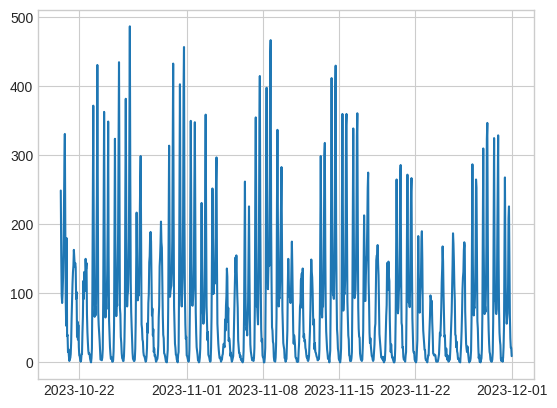

In [6]:
plt.plot(data['fremont_bridge'])

# Arima

Flow Diagram for ARIMA Time Series Analysis:
1. Data Preparation:
Gather the time series data and ensure it's in a suitable format.
Check for missing values and handle them if present.
2. Check for Seasonality:
Visualize the time series to observe any repetitive patterns or cycles. Use a decomposition plot to identify trend, seasonality, and residual components.
3. Assess Stationarity:
Plot the time series to visually inspect trends, rolling statistics, and stationarity.
Perform the Augmented Dickey-Fuller (ADF) test to check for stationarity.
4. Differencing:
Apply differencing to achieve stationarity if the series is non-stationary.
Check stationarity after differencing using the ADF test.
5. ACF and PACF Analysis:
Examine the Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) of the differenced series to determine the orders (p, d, q) for ARIMA.
6. Fit ARIMA Model:
Fit the ARIMA model to the differenced series using the determined orders (p, d, q).
Generate forecasts in the differenced space.
7. Inverse Differencing for Interpretation:
Invert the differencing process to translate the forecasts back to the original scale.
Apply cumulative sum to the forecasted differences to obtain predictions in the original scale.
8. Evaluate and Refine:
Assess the model's performance using appropriate evaluation metrics (e.g., MAE, RMSE).
Refine the model if necessary by adjusting parameters and re-fitting.

In [7]:
import warnings
import itertools
import statsmodels.api as sm

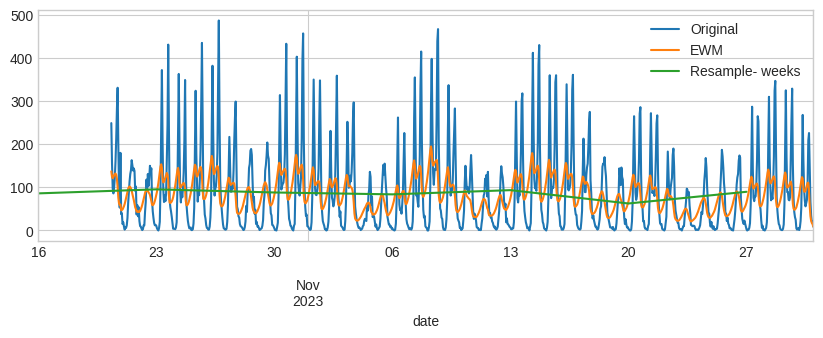

In [8]:
data["fremont_bridge"].plot(figsize=(10,3),label="Original")
data["fremont_bridge"].ewm(alpha=0.1).mean().plot(figsize=(10,3),label="EWM")
data["fremont_bridge"].resample("w").mean().plot(figsize=(10,3),label="Resample- weeks")
plt.legend()

In [9]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 2) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 2)
SARIMAX: (0, 0, 1) x (0, 1, 0, 2)
SARIMAX: (0, 1, 0) x (0, 1, 1, 2)
SARIMAX: (0, 1, 0) x (1, 0, 0, 2)


In [10]:
y = data["fremont_bridge"].copy().sort_index()

<Axes: xlabel='date'>

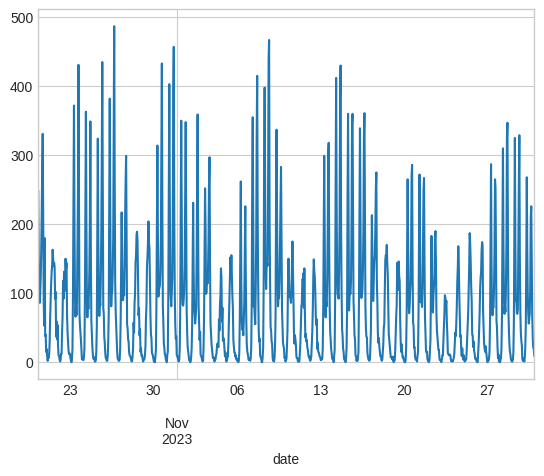

In [11]:
y.plot()


In [13]:
parameters,PARAMETERS,AIC=[],[],[]
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit(disp=-1)
            #print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            parameters.append(param)
            PARAMETERS.append(param_seasonal)
            AIC.append(results.aic)
        except:
            continue
resultados=pd.DataFrame({"Tendencia":parameters,"Estacionalidad":PARAMETERS,"AIC":AIC})

In [14]:
resultados

,Tendencia,Estacionalidad,AIC
0,"(0, 0, 0)","(0, 0, 0, 2)",12500.438877
1,"(0, 0, 0)","(0, 0, 1, 2)",12014.997480
2,"(0, 0, 0)","(0, 1, 0, 2)",11979.827197
3,"(0, 0, 0)","(0, 1, 1, 2)",11859.442403
4,"(0, 0, 0)","(1, 0, 0, 2)",11828.030143
...,...,...,...
59,"(1, 1, 1)","(0, 1, 1, 2)",10761.581281
60,"(1, 1, 1)","(1, 0, 0, 2)",10758.043488
61,"(1, 1, 1)","(1, 0, 1, 2)",10685.508920
62,"(1, 1, 1)","(1, 1, 0, 2)",11059.999028


In [15]:
resultados[resultados["AIC"]==resultados["AIC"].min()]


,Tendencia,Estacionalidad,AIC
47,"(1, 0, 1)","(1, 1, 1, 2)",10589.097204


In [18]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 0, 1),
                                seasonal_order=(1, 1, 1, 2),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5899      0.102      5.806      0.000       0.391       0.789
ma.L1          0.6319      0.096      6.588      0.000       0.444       0.820
ar.S.L2        0.1050      0.128      0.818      0.413      -0.147       0.357
ma.S.L2       -1.0000      5.591     -0.179      0.858     -11.958       9.958
sigma2      2423.2503   1.36e+04      0.179      0.858   -2.41e+04     2.9e+04


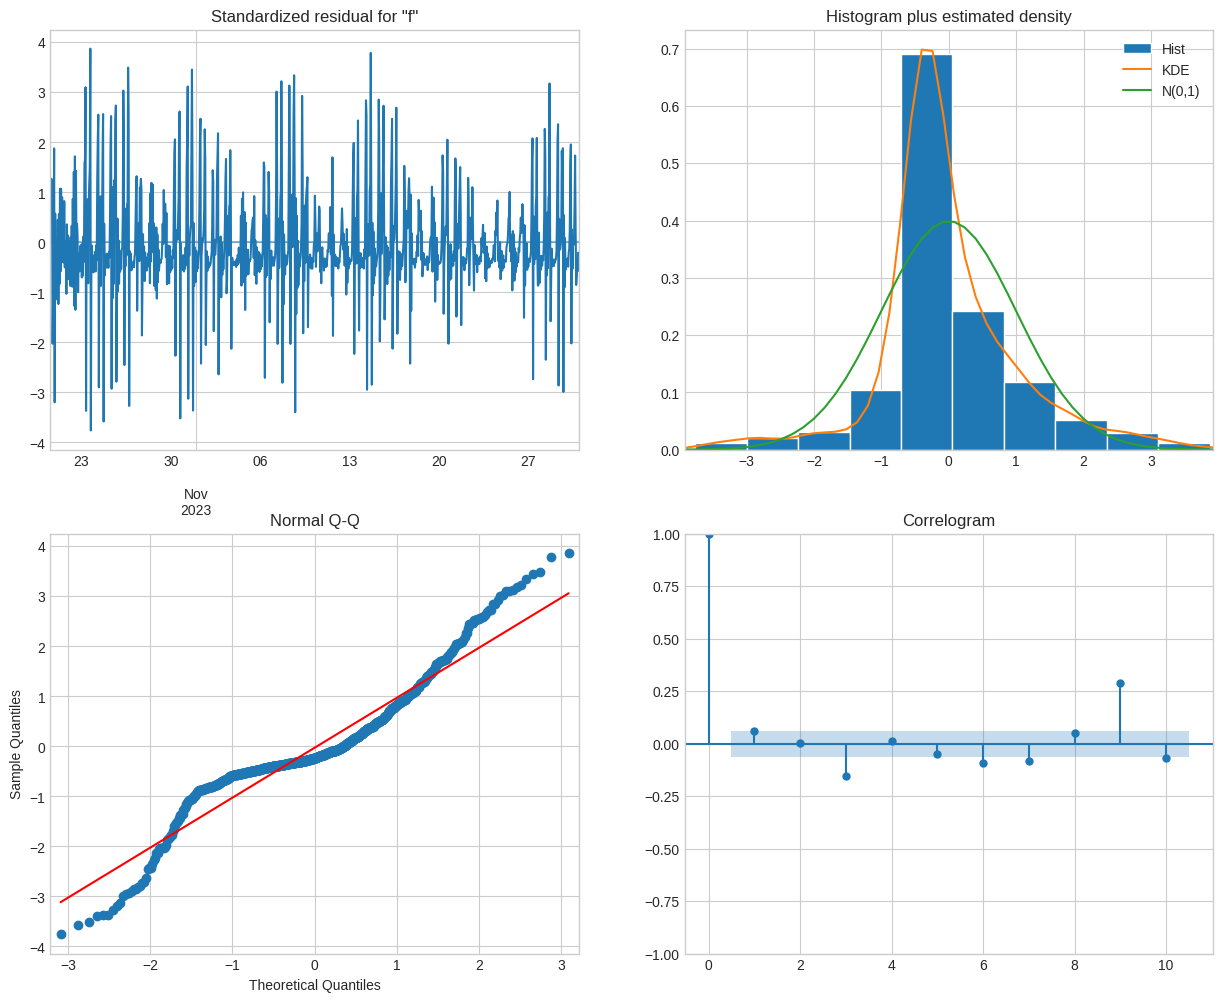

In [19]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [30]:
pred = results.get_prediction(start=pd.to_datetime('2023-11-25 00:00:00'), dynamic=False)
pred_ci = pred.conf_int()


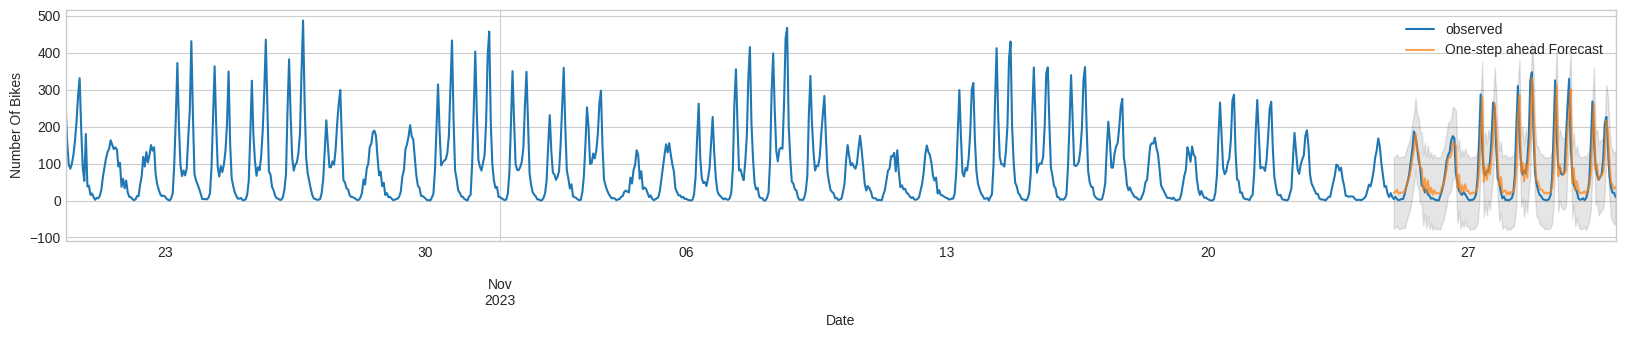

In [31]:
ax = y.plot(label='observed',figsize=(20,3))
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.1)

ax.set_xlabel('Date')
ax.set_ylabel('Number Of Bikes')
plt.legend()

In [33]:
from sklearn.metrics import r2_score, mean_squared_error
print("Root mean squared error =", np.sqrt(mean_squared_error(pred.predicted_mean,y["2023-11-25 00:00:00":])))
print("R2 score =", r2_score(pred.predicted_mean,y["2023-11-25 00:00:00":]))

Root mean squared error = 45.3763962338736
R2 score = 0.6072809342139673


In [34]:
from statsmodels.tsa.seasonal import seasonal_decompose

result_est = seasonal_decompose(y, model='add')


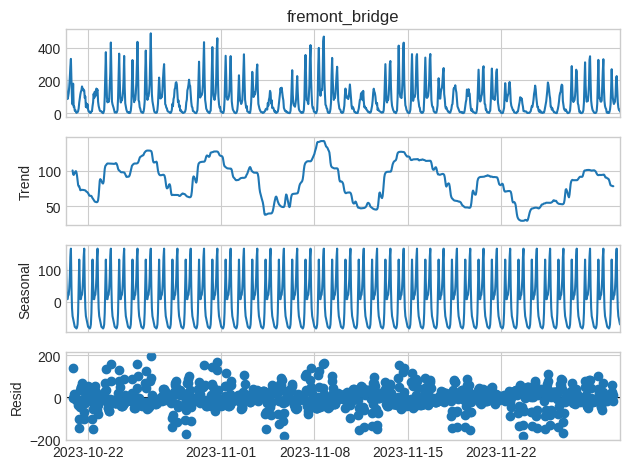

In [35]:
result_est.plot()
plt.show()

# LSTM